In [1]:
import os
import datetime

from time import perf_counter

from filtration import Filtration
from boundary import Boundary
from reducer import reduce_greedy, reduce_smart
from barcode import write_barcode, plot_barcode_reduction, build_intervals, betti_from_intervals, guess_space

def get_barcode(filtration_path: str, barcode_folder_path: str, method: str = "both") -> tuple[Boundary, object]:
    """
    Compute the persistent homology barcode from a filtration file.
    Args:
        filtration_path (str): Path to the filtration file.
        barcode_folder_path (str): Path to the output barcode file.
        method (str): Reduction method to use ("greedy", "smart", or "both").
    """

    assert method in ("greedy", "smart", "both"), "method must be one of 'greedy', 'smart', or 'both'."

    tps_filtration = datetime.datetime.now()
    filtration = Filtration.from_file(filtration_path)
    tps_filtration = (datetime.datetime.now() - tps_filtration).total_seconds()

    tps_boundary = datetime.datetime.now()
    boundary_base = Boundary.from_filtration(filtration, strict=True)
    tps_boundary = (datetime.datetime.now() - tps_boundary).total_seconds()

    input_filename = '.'.join(os.path.basename(filtration_path).split(".")[:-1])
    print(f"=== Computing barcode for filtration '{input_filename}' ===")

    if method in ("greedy", "both"):
        # Greedy
        boundary_greedy = boundary_base.copy()
        t0 = perf_counter()
        result_greedy, stats_greedy = reduce_greedy(boundary_greedy)
        t1 = perf_counter()
        write_barcode(
            boundary_greedy.simplices,
            result_greedy.lowest_row_of_col,
            result_greedy.birth_to_death,
            os.path.join(barcode_folder_path, f"{input_filename}_barcode_greedy.txt"),
        )
        tps_reduction = t1 - t0
        print(f"[greedy] time = {(t1 - t0)*1000:.3f} ms, "
            f"adds = {stats_greedy.column_additions}, pivots = {stats_greedy.pivots_finalized}")
        
        boundary, result = boundary_greedy, result_greedy

    if method in ("smart", "both"):
        # Smart
        boundary_smart = boundary_base.copy()
        t2 = perf_counter()
        result_smart, stats_smart = reduce_smart(boundary_smart)
        t3 = perf_counter()
        write_barcode(
            boundary_smart.simplices,
            result_smart.lowest_row_of_col,
            result_smart.birth_to_death,
            os.path.join(barcode_folder_path, f"{input_filename}_barcode_smart.txt"),
        )
        tps_reduction = t3 - t2
        print(f"[smart ] time = {(t3 - t2)*1000:.3f} ms, "
            f"adds = {stats_smart.column_additions}, pivots = {stats_smart.pivots_finalized}")
        
        boundary, result = boundary_smart, result_smart

    
    print(f"Filtration time: {tps_filtration} s")
    print(f"Boundary matrix construction time: {tps_boundary} s")
    print(f"Reduction time: {tps_reduction} s")
    print(f"Total time: {tps_filtration + tps_boundary + tps_reduction} s")

    return input_filename, boundary, result


In [2]:
filename, boundary, result = get_barcode(
    # filtration_path="../data/filtration/n-spheres/7-sphere.txt",
    filtration_path="../data/filtration/filtration_D.txt",
    barcode_folder_path="../data/barcodes/filtrations",
    method="greedy"
)

=== Computing barcode for filtration 'filtration_D' ===
[greedy] time = 170702.937 ms, adds = 20794762, pivots = 1358215
Filtration time: 6.225336 s
Boundary matrix construction time: 13.21584 s
Reduction time: 170.70293737528846 s
Total time: 190.14411337528844 s


Betti: {0: 1}
Guess: contractible


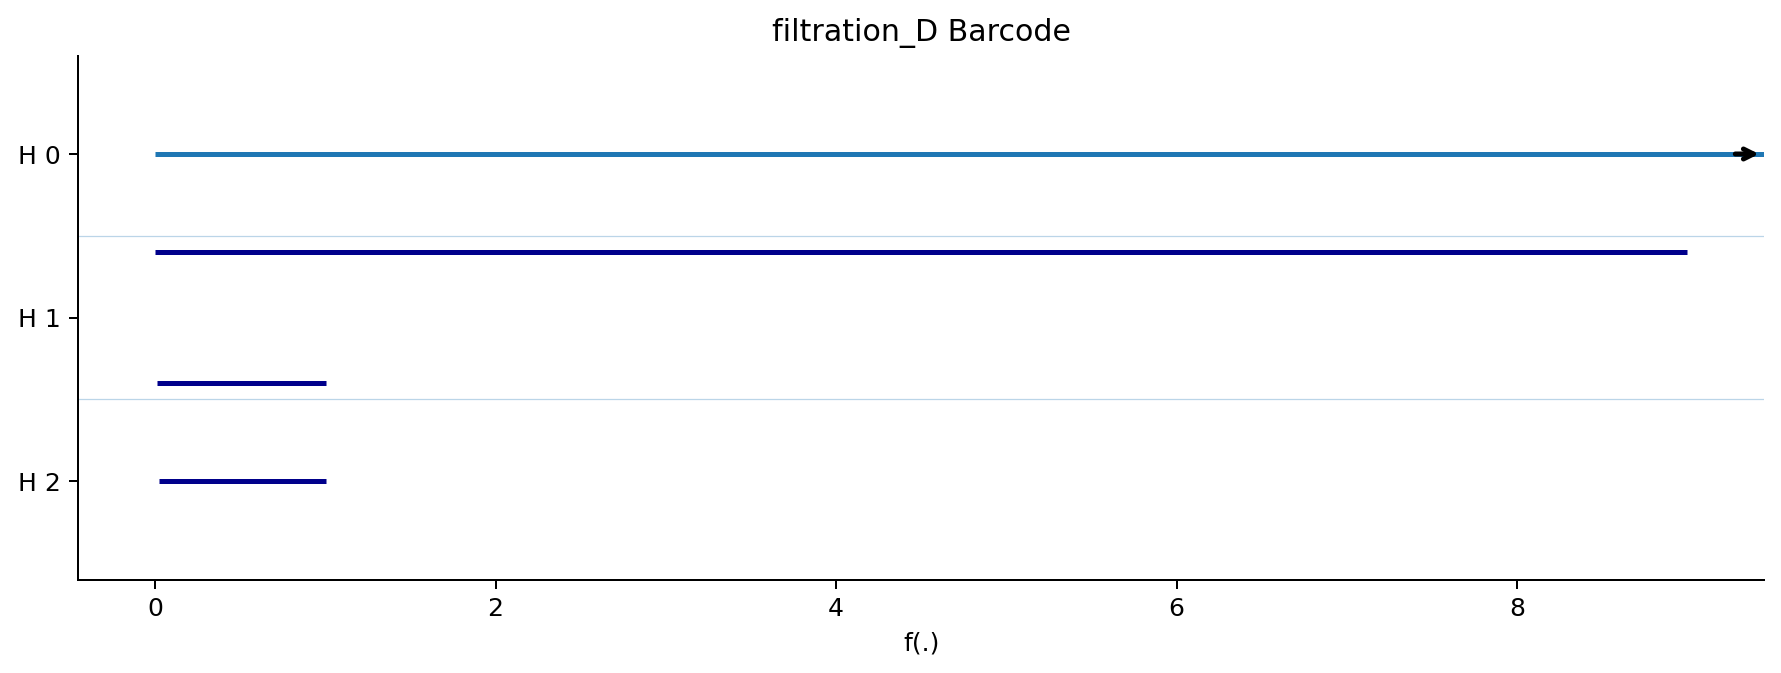

In [3]:
# 1) Betti & topology guess (on raw intervals)
intervals = build_intervals(boundary.simplices, result.lowest_row_of_col, result.birth_to_death)
betti = betti_from_intervals(intervals)
print("Betti:", betti)
print("Guess:", guess_space(betti))

plot_barcode_reduction(
    boundary.simplices, 
    result.lowest_row_of_col, 
    result.birth_to_death,
    outfile=f"../data/barcodes/filtrations/{filename}_barcode.png", 
    title=f"{filename} Barcode", 
    # x_mode="log_values", 
    min_length=0.05
)

In [4]:
raise Exception()
for idx in range(0, 10):
    start = datetime.datetime.now()
    filename, boundary, result = get_barcode(
        filtration_path=f"../data/filtration/n-balls/{idx}-ball.txt",
        # filtration_path="../data/filtration/filtration_A.txt",
        barcode_folder_path="../data/barcodes/n-balls",
        method="smart"
    )

    print(f"Computation for {idx}-ball took {(datetime.datetime.now() - start).total_seconds()}")

    intervals = build_intervals(boundary.simplices, result.lowest_row_of_col, result.birth_to_death)
    betti = betti_from_intervals(intervals)
    print("Betti:", betti)
    print("Guess:", guess_space(betti))

    plot_barcode_reduction(
        boundary.simplices, 
        result.lowest_row_of_col,
        result.birth_to_death,
        outfile=f"../data/barcodes/n-balls/{filename}_barcode.png", 
        title="Barcode for " + filename,
    )

Exception: 